In [3]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 230.1 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
from tensorflow.keras.datasets import mnist #Загружаем базу mnist
from tensorflow.keras.datasets import cifar10 #Загружаем базу cifar10
from tensorflow.keras.datasets import cifar100 #Загружаем базу cifar100

from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from sklearn.model_selection import train_test_split
import numpy as np #Библиотека работы с массивами
import matplotlib.pyplot as plt #Для отрисовки графиков
from PIL import Image #Для отрисовки изображений
import keras_tuner as kt
import random #Для генерации случайных чисел
import math # Для округления
import os #Для работы с файлами

%matplotlib inline

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x, y = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])

x = x / 255
y = utils.to_categorical(y, 10)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [14]:
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='silu'),
    Conv2D(32, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='silu'),
    Conv2D(64, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2)),

    Dropout(0.2),
    Conv2D(128, (3, 3), padding='same', activation='silu'),
    Conv2D(128, (3, 3), padding='same', activation='silu'),
    MaxPooling2D(pool_size=(2, 2), padding='same'),

    Dropout(0.2),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, verbose=True, epochs=20, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/20
375/375 [==============================] - 128s 340ms/step - loss: 1.3786 - accuracy: 0.4984 - val_loss: 2.1525 - val_accuracy: 0.2806
Epoch 2/20
375/375 [==============================] - 128s 342ms/step - loss: 0.8916 - accuracy: 0.6853 - val_loss: 0.8990 - val_accuracy: 0.6886
Epoch 3/20
375/375 [==============================] - 128s 342ms/step - loss: 0.6974 - accuracy: 0.7529 - val_loss: 0.8540 - val_accuracy: 0.7206
Epoch 4/20
375/375 [==============================] - 128s 341ms/step - loss: 0.5791 - accuracy: 0.7965 - val_loss: 0.6335 - val_accuracy: 0.7862
Epoch 5/20
375/375 [==============================] - 137s 366ms/step - loss: 0.4876 - accuracy: 0.8282 - val_loss: 0.6624 - val_accuracy: 0.7784
Epoch 6/20
375/375 [==============================] - 168s 448ms/step - loss: 0.4265 - accuracy: 0.8484 - val_loss: 0.6519 - val_accuracy: 0.7825
Epoch 7/20
375/375 [==============================] - 152s 407ms/step - loss: 0.3752 - accuracy: 0.8683 - val_loss: 0.6332 -

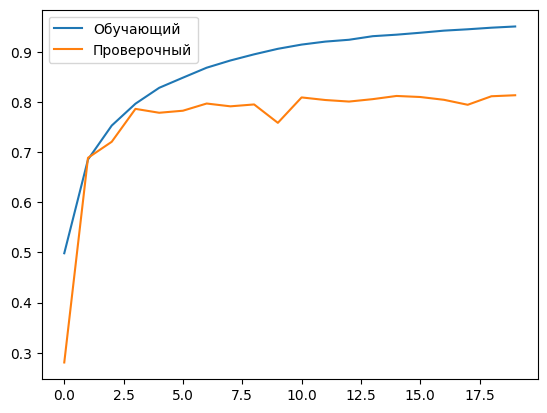

In [15]:
plt.plot(history.history['accuracy'], label='Обучающий')
plt.plot(history.history['val_accuracy'], label='Проверочный')
plt.legend()
plt.show()

In [21]:
batch_size = 32

train: tf.data.Dataset = utils.image_dataset_from_directory(
    directory='Автомобили/train',
    validation_split=0.2,
    subset='training',
    seed=123,
    batch_size=batch_size,
    image_size=(256, 256),
    label_mode='categorical'
)
val: tf.data.Dataset = utils.image_dataset_from_directory(
    directory='Автомобили/val',
    validation_split=0.2,
    subset='validation',
    seed=123,
    batch_size=batch_size,
    image_size=(256, 256),
    label_mode='categorical'
)

AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

Found 2743 files belonging to 3 classes.
Using 2195 files for training.
Found 684 files belonging to 3 classes.
Using 136 files for validation.


In [27]:
!rm -r proj

In [30]:
def create_model(hp: kt.engine.hyperparameters.HyperParameters):
    conv_filters = hp.Int('conv2d_filters', min_value=32, max_value=64, step=32)
    dense_size = hp.Int('dense_size', min_value=64, max_value=192, step=64)
    model = keras.Sequential([
        Rescaling(1 / .255),

        BatchNormalization(),
        Conv2D(conv_filters, 3, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Dropout(0.2),
        BatchNormalization(),
        Conv2D(conv_filters * 2, 3, activation='silu'),
        MaxPooling2D(pool_size=(2, 2)),

        Dropout(0.2),
        Flatten(),
        Dense(dense_size, activation='relu'),
        Dense(dense_size // 2, activation='relu'),
        Dense(3, activation='softmax'),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    hypermodel=create_model,
    objective='val_accuracy',
    max_trials=5,
    project_name='proj'
)

with tf.device('/device:GPU:0'):
  tuner.search(train, validation_data=val, epochs=5)

best_model = tuner.get_best_models()[0]
score = best_model.evaluate(val)
print(f'Точность на тестовых: {score[1]}')

Trial 5 Complete [00h 08m 26s]
val_accuracy: 0.5220588445663452

Best val_accuracy So Far: 0.5220588445663452
Total elapsed time: 01h 03m 16s
5/5 [==============================] - 2s 279ms/step - loss: 17.7802 - accuracy: 0.5221
Точность на тестовых: 0.5220588445663452
